# 1. Abstract

This document shows applying Deep Q-Learning Network model to a game SpaceInvaders(SpaceInvaders-v0) from Open AI Gym Atari.

Deep Q learning, as published in (Mnih et al, 2013), leverages advances in deep learning to learn policies from high dimensional sensory input. Specifically, it learns with raw pixels from Atari 2600 games using convolutional networks, instead of low-dimensional feature vectors.On a higher level, Deep Q learning works as such:
Gather and store samples in a replay buffer with current policy; Random sample batches of experiences from the replay buffer (known as Experience Replay);Use the sampled experiences to update the Q network; and repeat above[4].

After implementing for more than 11 hours, we get about 2000 episode results and several gif visualization results.Even though the outcome is not very perfect, it shows this game agent needs much more hours to train andif applied deep q-learning network.

# 2. Setting up the enivironment
Import libraries and install tensorflow(version=2.4).

In [5]:
# Run in environment tensorflow in the local, not base

#Import the libraiies
from tensorflow.keras import Sequential, layers
from collections import deque
from keras.models import Sequential

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

import random
import copy
import gym
import os
import cv2


In [6]:
# Reduce tensorflow warning level
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Configure GPU memory
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

# 3. Create deep Q-learning and train the agent
Initialize the environment, build deep Q-learning Network model, save memory, train the agent and choose action

In [3]:
class DQNAgent:
    #Set up hyperparameters
    def __init__(self, env):
        self._env = env
        self.memory = deque(maxlen=128)
        self.gamma = 0.5 # Discounting rate
        self.epsilon = 1.0
        self.epsilon_decay = 0.999 # exponential decay rate for exploration prob
        self.epsilon_min = 0.2 

        self.simple_size = 16

        self.model = self._Build_Deep_Q_Network()
        self.opt = tf.keras.optimizers.Adam()

    def _Build_Deep_Q_Network(self):
        model = Sequential()

        model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='valid'))
        model.add(layers.Activation('relu'))
        model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))

        model.add(layers.Flatten())
        model.add(layers.Dense(units=128, activation='relu'))
        model.add(layers.Dense(units=32, activation='relu'))
        model.add(layers.Dense(units=6))

        model.build(input_shape=(None, 40, 40, 1))
        model.summary()
        return model

    def save_memory(self, state, action, reward, next_state, done):

        _state = np.array([state], dtype=np.float64)/255.0
        _next_state = np.array([next_state], dtype=np.float64)/255.0

        self.memory.append((_state, action, reward, _next_state, done))


    def train(self):
        batchs = min(self.simple_size, len(self.memory))
        training_data = random.sample(self.memory, batchs)

        loss_sum = 0.
        count = 0
        for i in training_data:
            state, action, reward, next_state, done = i

            y_reward = reward
            if not done:
                y_reward = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

            _y = self.model.predict(state)
            _y[0][action] = y_reward

            with tf.GradientTape() as tape:
                loss = tf.losses.mean_squared_error(y_true=_y, y_pred=self.model(state))
                grad = tape.gradient(loss, self.model.trainable_variables)
                self.opt.apply_gradients(zip(grad, self.model.trainable_variables))
            loss_sum += loss

            count += 1

        if self.epsilon > self.epsilon_min:

            self.epsilon *= self.epsilon_decay

        print(" loss : {}".format(loss_sum / count))
        return loss_sum / count


    def choice_action(self, state):
        _state = np.array([state], dtype=np.float64)/255.0
        if np.random.rand() <= self.epsilon:
            return self._env.action_space.sample()
        else:
            action = self.model.predict(_state)
            return np.argmax(action[0])


# 4.Define the preprocessing function
Preprocessing is an important step, which can help reduce the complexity of our states to reduce the computation time needed for training

In [4]:
def preprocess(state):
    state = state[20:]
    state = np.mean(state, axis=2)
    state = cv2.resize(state, dsize=(40, 40))
    state = np.reshape(state, newshape=(40, 40, 1))

    state[state < 10] = 0
    state[state >= 10] = 255

    return state


# 5. Show episode result and visualize agent play

In [5]:
if __name__ == '__main__':
    env = gym.make('SpaceInvaders-v0')
    agent = DQNAgent(env)

    episodes = 10000

    all_loss = []
    for e in range(episodes):
        state = env.reset()
        state = preprocess(state)

        all_rewards = 0

        for time_t in range(5000):

            env.render()

            action = agent.choice_action(state)

            next_state, reward, done, _ = env.step(action)
            next_state = preprocess(next_state)

            if reward != 0.0:
                agent.save_memory(state, action, reward, next_state, done)

            state = copy.deepcopy(next_state)

            all_rewards += reward

            if done:
                print("episode: {}/{}, steps: {}, epsilon: {}"
                      .format(e + 1, episodes, time_t, agent.epsilon))
                break

        loss = agent.train()
        all_loss.append(loss[0])

    plt.plot(all_loss)
    plt.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 38, 38, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 38, 38, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 19, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 11552)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1478784   
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1

 loss : [8.331831]
episode: 90/10000, steps: 660, epsilon: 0.914804836692645
 loss : [9.676029]
episode: 91/10000, steps: 733, epsilon: 0.9138900318559524
 loss : [8.729343]
episode: 92/10000, steps: 392, epsilon: 0.9129761418240965
 loss : [9.406696]
episode: 93/10000, steps: 629, epsilon: 0.9120631656822724
 loss : [13.725804]
episode: 94/10000, steps: 884, epsilon: 0.9111511025165902
 loss : [7.220252]
episode: 95/10000, steps: 656, epsilon: 0.9102399514140735
 loss : [12.306911]
episode: 96/10000, steps: 1249, epsilon: 0.9093297114626595
 loss : [8.255973]
episode: 97/10000, steps: 676, epsilon: 0.9084203817511969
 loss : [3.3792112]
episode: 98/10000, steps: 535, epsilon: 0.9075119613694457
 loss : [8.643132]
episode: 99/10000, steps: 1419, epsilon: 0.9066044494080763
 loss : [356.7812]
episode: 100/10000, steps: 437, epsilon: 0.9056978449586682
 loss : [14.098992]
episode: 101/10000, steps: 906, epsilon: 0.9047921471137096
 loss : [25.687578]
episode: 102/10000, steps: 459, epsil

episode: 193/10000, steps: 568, epsilon: 0.8252275899809898
 loss : [8.295223]
episode: 194/10000, steps: 685, epsilon: 0.8244023623910088
 loss : [7.2063775]
episode: 195/10000, steps: 669, epsilon: 0.8235779600286178
 loss : [8.444803]
episode: 196/10000, steps: 675, epsilon: 0.8227543820685892
 loss : [7.1811056]
episode: 197/10000, steps: 779, epsilon: 0.8219316276865206
 loss : [5.8777356]
episode: 198/10000, steps: 652, epsilon: 0.8211096960588341
 loss : [11.860527]
episode: 199/10000, steps: 649, epsilon: 0.8202885863627752
 loss : [7.7345734]
episode: 200/10000, steps: 363, epsilon: 0.8194682977764125
 loss : [8.980623]
episode: 201/10000, steps: 751, epsilon: 0.818648829478636
 loss : [12.229623]
episode: 202/10000, steps: 602, epsilon: 0.8178301806491574
 loss : [4.390532]
episode: 203/10000, steps: 920, epsilon: 0.8170123504685082
 loss : [4.604148]
episode: 204/10000, steps: 842, epsilon: 0.8161953381180397
 loss : [8.751116]
episode: 205/10000, steps: 678, epsilon: 0.8153

episode: 296/10000, steps: 790, epsilon: 0.7444217038990517
 loss : [289.84592]
episode: 297/10000, steps: 806, epsilon: 0.7436772821951526
 loss : [77.4027]
episode: 298/10000, steps: 657, epsilon: 0.7429336049129575
 loss : [11.333845]
episode: 299/10000, steps: 797, epsilon: 0.7421906713080445
 loss : [7.4509788]
episode: 300/10000, steps: 616, epsilon: 0.7414484806367364
 loss : [3.9758067]
episode: 301/10000, steps: 384, epsilon: 0.7407070321560997
 loss : [6.3101835]
episode: 302/10000, steps: 591, epsilon: 0.7399663251239436
 loss : [6.7263174]
episode: 303/10000, steps: 625, epsilon: 0.7392263587988196
 loss : [10.140472]
episode: 304/10000, steps: 733, epsilon: 0.7384871324400207
 loss : [10.032749]
episode: 305/10000, steps: 769, epsilon: 0.7377486453075807
 loss : [13.851644]
episode: 306/10000, steps: 1208, epsilon: 0.737010896662273
 loss : [322.3882]
episode: 307/10000, steps: 915, epsilon: 0.7362738857656108
 loss : [13.040939]
episode: 308/10000, steps: 638, epsilon: 0.

episode: 399/10000, steps: 580, epsilon: 0.6715282910605703
 loss : [10.65386]
episode: 400/10000, steps: 676, epsilon: 0.6708567627695098
 loss : [11.885257]
episode: 401/10000, steps: 755, epsilon: 0.6701859060067403
 loss : [10.882977]
episode: 402/10000, steps: 775, epsilon: 0.6695157201007336
 loss : [9.335434]
episode: 403/10000, steps: 962, epsilon: 0.6688462043806328
 loss : [13.813673]
episode: 404/10000, steps: 723, epsilon: 0.6681773581762521
 loss : [6.4608693]
episode: 405/10000, steps: 919, epsilon: 0.6675091808180759
 loss : [353.25345]
episode: 406/10000, steps: 506, epsilon: 0.6668416716372578
 loss : [5.695059]
episode: 407/10000, steps: 833, epsilon: 0.6661748299656206
 loss : [12.34824]
episode: 408/10000, steps: 796, epsilon: 0.6655086551356549
 loss : [5.810475]
episode: 409/10000, steps: 809, epsilon: 0.6648431464805192
 loss : [10.610001]
episode: 410/10000, steps: 646, epsilon: 0.6641783033340387
 loss : [7.414697]
episode: 411/10000, steps: 513, epsilon: 0.663

episode: 502/10000, steps: 651, epsilon: 0.6057725659163237
 loss : [20.762182]
episode: 503/10000, steps: 622, epsilon: 0.6051667933504074
 loss : [27.543438]
episode: 504/10000, steps: 868, epsilon: 0.6045616265570569
 loss : [23.569103]
episode: 505/10000, steps: 890, epsilon: 0.6039570649304998
 loss : [8.840931]
episode: 506/10000, steps: 808, epsilon: 0.6033531078655693
 loss : [10.18484]
episode: 507/10000, steps: 839, epsilon: 0.6027497547577038
 loss : [15.215061]
episode: 508/10000, steps: 735, epsilon: 0.602147005002946
 loss : [397.75272]
episode: 509/10000, steps: 519, epsilon: 0.6015448579979431
 loss : [25.18781]
episode: 510/10000, steps: 614, epsilon: 0.6009433131399452
 loss : [15.330053]
episode: 511/10000, steps: 643, epsilon: 0.6003423698268052
 loss : [9.338488]
episode: 512/10000, steps: 740, epsilon: 0.5997420274569785
 loss : [11.831255]
episode: 513/10000, steps: 367, epsilon: 0.5991422854295215
 loss : [16.508245]
episode: 514/10000, steps: 783, epsilon: 0.59

episode: 605/10000, steps: 1191, epsilon: 0.5464556095429605
 loss : [11.448648]
episode: 606/10000, steps: 403, epsilon: 0.5459091539334175
 loss : [352.34488]
episode: 607/10000, steps: 505, epsilon: 0.5453632447794842
 loss : [21.319815]
episode: 608/10000, steps: 365, epsilon: 0.5448178815347047
 loss : [16.423155]
episode: 609/10000, steps: 630, epsilon: 0.54427306365317
 loss : [21.605484]
episode: 610/10000, steps: 1122, epsilon: 0.5437287905895168
 loss : [13.688934]
episode: 611/10000, steps: 640, epsilon: 0.5431850617989273
 loss : [9.027692]
episode: 612/10000, steps: 679, epsilon: 0.5426418767371284
 loss : [7.8997245]
episode: 613/10000, steps: 900, epsilon: 0.5420992348603912
 loss : [8.22858]
episode: 614/10000, steps: 966, epsilon: 0.5415571356255309
 loss : [19.601566]
episode: 615/10000, steps: 646, epsilon: 0.5410155784899053
 loss : [13.733649]
episode: 616/10000, steps: 318, epsilon: 0.5404745629114154
 loss : [9.608287]
episode: 617/10000, steps: 328, epsilon: 0.5

episode: 708/10000, steps: 649, epsilon: 0.4929469408197278
 loss : [333.39835]
episode: 709/10000, steps: 833, epsilon: 0.49245399387890804
 loss : [7.5943446]
episode: 710/10000, steps: 966, epsilon: 0.4919615398850291
 loss : [6.2653856]
episode: 711/10000, steps: 830, epsilon: 0.4914695783451441
 loss : [3.9962382]
episode: 712/10000, steps: 864, epsilon: 0.4909781087667989
 loss : [5.656607]
episode: 713/10000, steps: 827, epsilon: 0.4904871306580321
 loss : [7.5688057]
episode: 714/10000, steps: 804, epsilon: 0.4899966435273741
 loss : [7.344096]
episode: 715/10000, steps: 776, epsilon: 0.4895066468838467
 loss : [6.8100204]
episode: 716/10000, steps: 772, epsilon: 0.48901714023696286
 loss : [7.6716433]
episode: 717/10000, steps: 781, epsilon: 0.4885281230967259
 loss : [5.3294706]
episode: 718/10000, steps: 888, epsilon: 0.48803959497362914
 loss : [3.400878]
episode: 719/10000, steps: 843, epsilon: 0.4875515553786555
 loss : [7.6847486]
episode: 720/10000, steps: 779, epsilon:

 loss : [339.77985]
episode: 811/10000, steps: 673, epsilon: 0.44467781503197196
 loss : [15.44129]
episode: 812/10000, steps: 654, epsilon: 0.44423313721693997
 loss : [7.290557]
episode: 813/10000, steps: 1124, epsilon: 0.44378890407972305
 loss : [285.44354]
episode: 814/10000, steps: 851, epsilon: 0.44334511517564335
 loss : [223.08075]
episode: 815/10000, steps: 494, epsilon: 0.4429017700604677
 loss : [31.465508]
episode: 816/10000, steps: 546, epsilon: 0.44245886829040726
 loss : [16.808292]
episode: 817/10000, steps: 878, epsilon: 0.44201640942211684
 loss : [21.39233]
episode: 818/10000, steps: 489, epsilon: 0.44157439301269474
 loss : [16.732914]
episode: 819/10000, steps: 670, epsilon: 0.44113281861968207
 loss : [54.560585]
episode: 820/10000, steps: 648, epsilon: 0.4406916858010624
 loss : [16.630707]
episode: 821/10000, steps: 455, epsilon: 0.4402509941152613
 loss : [26.692577]
episode: 822/10000, steps: 1117, epsilon: 0.43981074312114604
 loss : [370.77823]
episode: 823

episode: 913/10000, steps: 633, epsilon: 0.4015367153875324
 loss : [7.1697507]
episode: 914/10000, steps: 545, epsilon: 0.4011351786721449
 loss : [12.221874]
episode: 915/10000, steps: 936, epsilon: 0.40073404349347275
 loss : [5.10757]
episode: 916/10000, steps: 835, epsilon: 0.40033330944997925
 loss : [10.810204]
episode: 917/10000, steps: 1414, epsilon: 0.39993297614052925
 loss : [8.212806]
episode: 918/10000, steps: 783, epsilon: 0.3995330431643887
 loss : [19.058588]
episode: 919/10000, steps: 667, epsilon: 0.39913351012122433
 loss : [15.5748]
episode: 920/10000, steps: 860, epsilon: 0.3987343766111031
 loss : [7.2167435]
episode: 921/10000, steps: 806, epsilon: 0.398335642234492
 loss : [13.480102]
episode: 922/10000, steps: 801, epsilon: 0.3979373065922575
 loss : [7.6646843]
episode: 923/10000, steps: 887, epsilon: 0.39753936928566525
 loss : [14.515573]
episode: 924/10000, steps: 637, epsilon: 0.3971418299163796
 loss : [365.15045]
episode: 925/10000, steps: 845, epsilon:

episode: 1015/10000, steps: 663, epsilon: 0.36258101563401773
 loss : [10.408445]
episode: 1016/10000, steps: 393, epsilon: 0.3622184346183837
 loss : [386.97574]
episode: 1017/10000, steps: 1228, epsilon: 0.36185621618376534
 loss : [362.91943]
episode: 1018/10000, steps: 808, epsilon: 0.36149435996758156
 loss : [19.602533]
episode: 1019/10000, steps: 786, epsilon: 0.361132865607614
 loss : [40.5557]
episode: 1020/10000, steps: 887, epsilon: 0.36077173274200636
 loss : [6.8905582]
episode: 1021/10000, steps: 828, epsilon: 0.36041096100926434
 loss : [11.624802]
episode: 1022/10000, steps: 871, epsilon: 0.3600505500482551
 loss : [372.18304]
episode: 1023/10000, steps: 817, epsilon: 0.35969049949820686
 loss : [3.4831176]
episode: 1024/10000, steps: 828, epsilon: 0.3593308089987087
 loss : [337.10977]
episode: 1025/10000, steps: 1150, epsilon: 0.35897147818971
 loss : [316.76413]
episode: 1026/10000, steps: 1157, epsilon: 0.3586125067115203
 loss : [11.137022]
episode: 1027/10000, ste

episode: 1116/10000, steps: 603, epsilon: 0.32773239518253433
 loss : [10.945991]
episode: 1117/10000, steps: 962, epsilon: 0.3274046627873518
 loss : [9.948686]
episode: 1118/10000, steps: 975, epsilon: 0.32707725812456445
 loss : [14.012023]
episode: 1119/10000, steps: 538, epsilon: 0.32675018086643987
 loss : [25.600288]
episode: 1120/10000, steps: 518, epsilon: 0.32642343068557345
 loss : [26.257326]
episode: 1121/10000, steps: 1006, epsilon: 0.3260970072548879
 loss : [247.49544]
episode: 1122/10000, steps: 1466, epsilon: 0.325770910247633
 loss : [26.54144]
episode: 1123/10000, steps: 658, epsilon: 0.32544513933738534
 loss : [11.8369]
episode: 1124/10000, steps: 654, epsilon: 0.3251196941980479
 loss : [25.295036]
episode: 1125/10000, steps: 718, epsilon: 0.32479457450384985
 loss : [11.087052]
episode: 1126/10000, steps: 672, epsilon: 0.324469779929346
 loss : [13.124035]
episode: 1127/10000, steps: 713, epsilon: 0.32414531014941667
 loss : [26.878668]
episode: 1128/10000, step

episode: 1217/10000, steps: 785, epsilon: 0.29623316781840775
 loss : [19.48968]
episode: 1218/10000, steps: 789, epsilon: 0.29593693465058934
 loss : [2.5654562]
episode: 1219/10000, steps: 792, epsilon: 0.29564099771593877
 loss : [29.120338]
episode: 1220/10000, steps: 642, epsilon: 0.2953453567182228
 loss : [5.69614]
episode: 1221/10000, steps: 474, epsilon: 0.2950500113615046
 loss : [2.7502103]
episode: 1222/10000, steps: 402, epsilon: 0.2947549613501431
 loss : [7.965414]
episode: 1223/10000, steps: 649, epsilon: 0.294460206388793
 loss : [8.414908]
episode: 1224/10000, steps: 934, epsilon: 0.2941657461824042
 loss : [9.158173]
episode: 1225/10000, steps: 814, epsilon: 0.2938715804362218
 loss : [12.288383]
episode: 1226/10000, steps: 1375, epsilon: 0.2935777088557856
 loss : [167.62769]
episode: 1227/10000, steps: 919, epsilon: 0.2932841311469298
 loss : [3.7621691]
episode: 1228/10000, steps: 618, epsilon: 0.2929908470157829
 loss : [8.39559]
episode: 1229/10000, steps: 817, 

 loss : [267.4002]
episode: 1319/10000, steps: 863, epsilon: 0.2674936530982436
 loss : [18.49612]
episode: 1320/10000, steps: 661, epsilon: 0.26722615944514533
 loss : [74.67768]
episode: 1321/10000, steps: 811, epsilon: 0.2669589332857002
 loss : [21.460003]
episode: 1322/10000, steps: 797, epsilon: 0.2666919743524145
 loss : [10.60117]
episode: 1323/10000, steps: 821, epsilon: 0.26642528237806207
 loss : [19.866064]
episode: 1324/10000, steps: 658, epsilon: 0.266158857095684
 loss : [14.262849]
episode: 1325/10000, steps: 844, epsilon: 0.2658926982385883
 loss : [8.029356]
episode: 1326/10000, steps: 795, epsilon: 0.26562680554034973
 loss : [7.112507]
episode: 1327/10000, steps: 781, epsilon: 0.26536117873480936
 loss : [5.6215196]
episode: 1328/10000, steps: 932, epsilon: 0.26509581755607453
 loss : [6.5695934]
episode: 1329/10000, steps: 584, epsilon: 0.26483072173851846
 loss : [6.2789903]
episode: 1330/10000, steps: 644, epsilon: 0.26456589101677996
 loss : [9.256517]
episode: 

 loss : [2.1788323]
episode: 1420/10000, steps: 790, epsilon: 0.24178413056932346
 loss : [7.984494]
episode: 1421/10000, steps: 894, epsilon: 0.24154234643875414
 loss : [2.6035047]
episode: 1422/10000, steps: 668, epsilon: 0.24130080409231539
 loss : [3.4284859]
episode: 1423/10000, steps: 1360, epsilon: 0.24105950328822306
 loss : [7.198179]
episode: 1424/10000, steps: 1806, epsilon: 0.24081844378493483
 loss : [287.19116]
episode: 1425/10000, steps: 847, epsilon: 0.2405776253411499
 loss : [408.40875]
episode: 1426/10000, steps: 820, epsilon: 0.24033704771580874
 loss : [8.131878]
episode: 1427/10000, steps: 829, epsilon: 0.24009671066809293
 loss : [7.8482914]
episode: 1428/10000, steps: 898, epsilon: 0.23985661395742483
 loss : [6.2913933]
episode: 1429/10000, steps: 640, epsilon: 0.2396167573434674
 loss : [4.3501215]
episode: 1430/10000, steps: 789, epsilon: 0.23937714058612394
 loss : [420.59857]
episode: 1431/10000, steps: 831, epsilon: 0.23913776344553783
 loss : [71.27079]


 loss : [22.183989]
episode: 1521/10000, steps: 1167, epsilon: 0.21854561825320348
 loss : [12.851026]
episode: 1522/10000, steps: 1260, epsilon: 0.21832707263495027
 loss : [43.922485]
episode: 1523/10000, steps: 558, epsilon: 0.21810874556231533
 loss : [341.85547]
episode: 1524/10000, steps: 619, epsilon: 0.217890636816753
 loss : [38.034466]
episode: 1525/10000, steps: 1116, epsilon: 0.21767274617993623
 loss : [17.607824]
episode: 1526/10000, steps: 1121, epsilon: 0.2174550734337563
 loss : [21.442184]
episode: 1527/10000, steps: 971, epsilon: 0.21723761836032254
 loss : [18.23622]
episode: 1528/10000, steps: 624, epsilon: 0.21702038074196223
 loss : [20.00313]
episode: 1529/10000, steps: 510, epsilon: 0.21680336036122028
 loss : [336.9256]
episode: 1530/10000, steps: 618, epsilon: 0.21658655700085905
 loss : [5.6384478]
episode: 1531/10000, steps: 1114, epsilon: 0.2163699704438582
 loss : [305.2]
episode: 1532/10000, steps: 630, epsilon: 0.21615360047341434
 loss : [265.50922]
ep

 loss : [150.46375]
episode: 1622/10000, steps: 358, epsilon: 0.19992658861601492
 loss : [9.877317]
episode: 1623/10000, steps: 377, epsilon: 0.19992658861601492
 loss : [7.00169]
episode: 1624/10000, steps: 808, epsilon: 0.19992658861601492
 loss : [12.145598]
episode: 1625/10000, steps: 413, epsilon: 0.19992658861601492
 loss : [8.081223]
episode: 1626/10000, steps: 868, epsilon: 0.19992658861601492
 loss : [6.244005]
episode: 1627/10000, steps: 652, epsilon: 0.19992658861601492
 loss : [10.70327]
episode: 1628/10000, steps: 652, epsilon: 0.19992658861601492
 loss : [5.7465873]
episode: 1629/10000, steps: 945, epsilon: 0.19992658861601492
 loss : [7.254288]
episode: 1630/10000, steps: 380, epsilon: 0.19992658861601492
 loss : [5.5750284]
episode: 1631/10000, steps: 392, epsilon: 0.19992658861601492
 loss : [18.371912]
episode: 1632/10000, steps: 731, epsilon: 0.19992658861601492
 loss : [12.811673]
episode: 1633/10000, steps: 773, epsilon: 0.19992658861601492
 loss : [8.89652]
episo

 loss : [5.940935]
episode: 1723/10000, steps: 899, epsilon: 0.19992658861601492
 loss : [10.06136]
episode: 1724/10000, steps: 785, epsilon: 0.19992658861601492
 loss : [6.878736]
episode: 1725/10000, steps: 1874, epsilon: 0.19992658861601492
 loss : [11.116806]
episode: 1726/10000, steps: 812, epsilon: 0.19992658861601492
 loss : [11.328137]
episode: 1727/10000, steps: 802, epsilon: 0.19992658861601492
 loss : [5.459611]
episode: 1728/10000, steps: 678, epsilon: 0.19992658861601492
 loss : [93.60383]
episode: 1729/10000, steps: 1480, epsilon: 0.19992658861601492
 loss : [23.758724]
episode: 1730/10000, steps: 1076, epsilon: 0.19992658861601492
 loss : [16.247162]
episode: 1731/10000, steps: 813, epsilon: 0.19992658861601492
 loss : [167.6563]
episode: 1732/10000, steps: 854, epsilon: 0.19992658861601492
 loss : [6.035251]
episode: 1733/10000, steps: 979, epsilon: 0.19992658861601492
 loss : [7.2121778]
episode: 1734/10000, steps: 512, epsilon: 0.19992658861601492
 loss : [129.92989]


episode: 1823/10000, steps: 427, epsilon: 0.19992658861601492
 loss : [9.879454]
episode: 1824/10000, steps: 692, epsilon: 0.19992658861601492
 loss : [11.322287]
episode: 1825/10000, steps: 819, epsilon: 0.19992658861601492
 loss : [12.075897]
episode: 1826/10000, steps: 706, epsilon: 0.19992658861601492
 loss : [8.224628]


KeyboardInterrupt: 

# 6. Conclusion
After about 12 hours' training, there are nearly 2000 episode results and we get several gif visualization (at epsidoe =250, 500, 1255, 1510, and 1740, see them in attached gifs).
Through the analysis and comparison of the results, we can conclude that deep-q learning network has a certain effect to this game, because this agent can get higher score and performs better and better along with trainning. 
However, the difficulty of adjusting parameters is relatively high and the learning for this agent is slow and it still need much more hours to train to get idea outcomes.So deep-q learning is not the perfect model to SpaceInvaders game. 

# 7. Questions Answers

#1. Establish a baseline performance

Implementation is showed above.

In this performance:
memory = deque(maxlen=128)
gamma = 0.5  # Discounting rate
epsilon = 1.0
epsilon_decay = 0.999 # exponential decay rate for exploration prob
epsilon_min = 0.2
simple_size = 16 # action size
input_shape=(None, 40, 40, 1) # state size
total_episodes = 10000  

The agent need much more time to train in order to get a perfect result. So this model is not very suitable for this game.

#2.The states, the actions, and the size of the Q-table

States: 
Whether the agent get strike from invaders or/and agent shoot invaders or flying bonus taget and how much score the agent earn from shooting invaders and bonus.

Actions:
The agent moves to shoot or dodge attack and choose to launch laser or not. 

Size:
Q-table has a row for each possible state and a column for each possible action.
states should have: shoot invader, shoot nothing, shoot bonus, get strike, only move, death
action size=16
So it is:16*6

#3.The rewards

In this SpaceInvaders game, the reward is the points which represents how many invaders the agent shoot and destroy and how many bonus the agent can shoot.
The game's goal is to kill as many enemies as possible and can get bonus as well while trying the best to protect the agent itself by moving and get sheltered. Trying to shoot bonus flying at far is challenging, it can add difficulty and fun when trying to avoid invaders' attack. So set this reward can achive this game goal best so that to attact the players.

#4.Alpha and gamma in the Bellman equation

Alpha is the learning rate, set generally between 0 and 1. Setting the alpha value to 0 means that the Q-values are never updated, thereby nothing is learned. If we set the alpha to a high value such as 0.9, it means that the learning can occur quickly.Learning rate is how big you take a leap in finding optimal policy. Higher alpha means you are updating your Q values in big steps.
Gamma is the discount factor that is set between 0 and 1. This models the fact that future rewards are worth less than immediate rewards.the return at the time t can be obtained using the return at the time t+1.

Thus, alpha is the learning rate. If the reward or transition function is random, then alpha should change over the period, approaching zero at infinity. This has to effect approximating the expected outcome of an inner product (T(transition)*R(reward)), when one of the two, or both, has random behavior.
Whereas, gamma is the value of future rewards. It can change the learning quite a bit and can be a dynamic or static value. If it is equal to one, the agent values future reward just as much as a current reward. This means, in ten actions, if an agent does something good this is just as valuable as doing this action directly. So learning doesn't work well at high gamma values.
Similarly, a gamma of zero will cause the agent to only value immediate rewards, which only works with very detailed reward functions.

Try at least one additional value for alpha and gamma:
Baseline performance changed shown in the run result：

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 38, 38, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 38, 38, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 19, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 11552)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1478784   
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_5 (Dense)              (None, 6)                

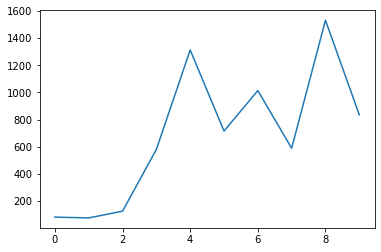

In [9]:
class DQNAgent2:
    def __init__(self, env):
        self._env = env
        self.memory = deque(maxlen=128)
        self.gamma = 0.8 #changed
        self.epsilon = 1  
        self.epsilon_decay = 0.999 
        self.epsilon_min = 0.5 #changed

        self.simple_size = 16

        self.model = self._Build_Deep_Q_Network()
        self.opt = tf.keras.optimizers.Adam()

    def _Build_Deep_Q_Network(self):
        model = Sequential()

        model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='valid'))
        model.add(layers.Activation('relu'))
        model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))

        model.add(layers.Flatten())
        model.add(layers.Dense(units=128, activation='relu'))
        model.add(layers.Dense(units=32, activation='relu'))
        model.add(layers.Dense(units=6))

        model.build(input_shape=(None, 40, 40, 1))
        model.summary()
        return model

    def save_memory(self, state, action, reward, next_state, done):

        _state = np.array([state], dtype=np.float64)/255.0
        _next_state = np.array([next_state], dtype=np.float64)/255.0

        self.memory.append((_state, action, reward, _next_state, done))


    def train(self):
        batchs = min(self.simple_size, len(self.memory))
        training_data = random.sample(self.memory, batchs)

        loss_sum = 0.
        count = 0
        for i in training_data:
            state, action, reward, next_state, done = i

            y_reward = reward
            if not done:
                y_reward = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

            _y = self.model.predict(state)
            _y[0][action] = y_reward

            with tf.GradientTape() as tape:
                loss = tf.losses.mean_squared_error(y_true=_y, y_pred=self.model(state))
                grad = tape.gradient(loss, self.model.trainable_variables)
                self.opt.apply_gradients(zip(grad, self.model.trainable_variables))
            loss_sum += loss

            count += 1

        if self.epsilon > self.epsilon_min:

            self.epsilon *= self.epsilon_decay

        print(" loss : {}".format(loss_sum / count))
        return loss_sum / count


    def choice_action(self, state):
        _state = np.array([state], dtype=np.float64)/255.0
        if np.random.rand() <= self.epsilon:
            return self._env.action_space.sample()
        else:
            action = self.model.predict(_state)
            return np.argmax(action[0])

def preprocess(state):
    state = state[20:]
    state = np.mean(state, axis=2)
    state = cv2.resize(state, dsize=(40, 40))
    state = np.reshape(state, newshape=(40, 40, 1))

    state[state < 10] = 0
    state[state >= 10] = 255

    return state

if __name__ == '__main__':
    env = gym.make('SpaceInvaders-v0')
    agent = DQNAgent2(env)

    episodes = 10

    all_loss = []
    for e in range(episodes):
        state = env.reset()
        state = preprocess(state)

        all_rewards = 0

        for time_t in range(5000):

            action = agent.choice_action(state)

            next_state, reward, done, _ = env.step(action)
            next_state = preprocess(next_state)

            if reward != 0.0:
                agent.save_memory(state, action, reward, next_state, done)

            state = copy.deepcopy(next_state)

            all_rewards += reward

            if done:
                print("episode: {}/{}, steps: {}, epsilon: {}"
                      .format(e + 1, episodes, time_t, agent.epsilon))
                break

        loss = agent.train()
        all_loss.append(loss[0])

    plt.plot(all_loss)
    plt.show()

#5.Policy other than maxQ(s', a')

If policy is not maxQ(s',a'), the learning target will change.

If I change the policy to stay survive as long as possible, the agent will ignore the shooting score and bonus and try best to hide under the shelter and move to avoide attack gradually along with more and more training. 

#6.Decay rate and starting epsilon

Epsilon is used when selecting specific actions base on the Q values we already have. As an example if I select pure greedy method ( epsilon = 0 ) then it will always selecting the highest q value among the all the q values for a specific state. This causes issue in exploration as I can get stuck easily at a local optima. Therefore introducing a randomness using epsilon is a good idea. 

Since epsilon denotes the amount of randomness in the policy (action is greedy with probability 1-epsilon and random with probability epsilon), I want to start with a fairly randomized policy and later slowly move towards a deterministic policy. Therefore, I usually start with a large epsilon and decay it to a small value. Most common and simple approaches are linear decay and exponential decay. 

Try at least one additional value for epsilon and the decay rate:
Baseline performance changed shown in the run result：
Reach max steps: 1526, and epsilon is 0.14770414800000004

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 38, 38, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 38, 38, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 19, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 11552)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1478784   
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1

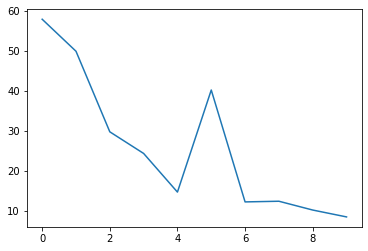

In [8]:
class DQNAgent3:
    def __init__(self, env):
        self._env = env
        self.memory = deque(maxlen=128)
        self.gamma = 0.5
        self.epsilon = 0.5  #changed
        self.epsilon_decay = 0.666 #changed
        self.epsilon_min = 0.2

        self.simple_size = 16

        self.model = self._Build_Deep_Q_Network()
        self.opt = tf.keras.optimizers.Adam()

    def _Build_Deep_Q_Network(self):
        model = Sequential()

        model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='valid'))
        model.add(layers.Activation('relu'))
        model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))

        model.add(layers.Flatten())
        model.add(layers.Dense(units=128, activation='relu'))
        model.add(layers.Dense(units=32, activation='relu'))
        model.add(layers.Dense(units=6))

        model.build(input_shape=(None, 40, 40, 1))
        model.summary()
        return model

    def save_memory(self, state, action, reward, next_state, done):

        _state = np.array([state], dtype=np.float64)/255.0
        _next_state = np.array([next_state], dtype=np.float64)/255.0

        self.memory.append((_state, action, reward, _next_state, done))


    def train(self):
        batchs = min(self.simple_size, len(self.memory))
        training_data = random.sample(self.memory, batchs)

        loss_sum = 0.
        count = 0
        for i in training_data:
            state, action, reward, next_state, done = i

            y_reward = reward
            if not done:
                y_reward = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

            _y = self.model.predict(state)
            _y[0][action] = y_reward

            with tf.GradientTape() as tape:
                loss = tf.losses.mean_squared_error(y_true=_y, y_pred=self.model(state))
                grad = tape.gradient(loss, self.model.trainable_variables)
                self.opt.apply_gradients(zip(grad, self.model.trainable_variables))
            loss_sum += loss

            count += 1

        if self.epsilon > self.epsilon_min:

            self.epsilon *= self.epsilon_decay

        print(" loss : {}".format(loss_sum / count))
        return loss_sum / count


    def choice_action(self, state):
        _state = np.array([state], dtype=np.float64)/255.0
        if np.random.rand() <= self.epsilon:
            return self._env.action_space.sample()
        else:
            action = self.model.predict(_state)
            return np.argmax(action[0])

def preprocess(state):
    state = state[20:]
    state = np.mean(state, axis=2)
    state = cv2.resize(state, dsize=(40, 40))
    state = np.reshape(state, newshape=(40, 40, 1))

    state[state < 10] = 0
    state[state >= 10] = 255

    return state

if __name__ == '__main__':
    env = gym.make('SpaceInvaders-v0')
    agent = DQNAgent3(env)

    episodes = 10

    all_loss = []
    for e in range(episodes):
        state = env.reset()
        state = preprocess(state)

        all_rewards = 0

        for time_t in range(5000):

            action = agent.choice_action(state)

            next_state, reward, done, _ = env.step(action)
            next_state = preprocess(next_state)

            if reward != 0.0:
                agent.save_memory(state, action, reward, next_state, done)

            state = copy.deepcopy(next_state)

            all_rewards += reward

            if done:
                print("episode: {}/{}, steps: {}, epsilon: {}"
                      .format(e + 1, episodes, time_t, agent.epsilon))
                break

        loss = agent.train()
        all_loss.append(loss[0])

    plt.plot(all_loss)
    plt.show()

#7. Average number of steps taken per episode

Detailed average steps for each episode is shown in part 5 result.

#8.Does Q-learning use value-based or policy-based iteration?

Q learning is a value-based off-policy temporal difference(TD) reinforcement learning. Off-policy means an agent follows a behaviour policy for choosing the action to reach the next state s_t+1 from state s_t. From s_t+1, it uses a policy π that is different from behaviour policy.

#9.Could you use SARSA for this problem? 

No, SARSA is not suitable for this problem.
The main difference between SARSA and Q-learning is that SARSA is on-policy -- it learns the values of acting including the action choices used for exploration.All variants of SARSA are on-policy algorithms. This means that they learn Q-values for the policy that they are also following to generate experience.
We take SpaceInvaders game by deep Q learning, our goal is to maximize the shooting score of the agent.We don't need the agent to change the policy or make the goal and action flexible by itself.This game should eventually settle down on a single policy, such that your Q values can converge to the values that are optimal for that policy.


#10.The expected lifetime value in the Bellman equation

Mathematically we can define Bellman Expectation Equation as :
![image-6.png](attachment:image-6.png)
The above equation tells us that the value of a particular state is determined by the immediate reward plus the value of successor states when we are following a certain policy(π).

The term 'Bellman equation' usually refers to the dynamic programming equation associated with discrete-time optimization problems.Dynamic programming breaks a multi-period planning problem into simpler steps at different points in time. Therefore, it requires keeping track of how the decision situation is evolving over time.The Bellman equation is classified as a functional equation, because solving it means finding the unknown function V, which is the value function. Recall that the value function describes the best possible value of the objective, as a function of the state x. By calculating the value function, we will also find the function a(x) that describes the optimal action as a function of the state; this is called the policy function[3].


#11.When would SARSA likely do better than Q-learning?

Q-learning assumes that the agent is following the best possible policy without attempting to resolve what that policy actually is, while SARSA takes into account the agent's actual policy (that is, what it ends up doing when it moves to the next state as opposed to the best possible thing it could be assumed to do).
If the goal is to train an optimal agent in simulation, or in a low-cost and fast-iterating environment, then Q-learning is a good choice, due to the first point (learning optimal policy directly). If the agent learns online, and you care about rewards gained whilst learning, then SARSA may be a better choice.
In many problems, SARSA will perform better than Q-learning, especially when there is a good chance that the agent will choose to take a random suboptimal action in the next step.Q-learning's assumption that the agent is following the optimal policy may be far enough from true that SARSA will converge faster and with fewer errors.


#12. SARSA differ from Q-learning

Sarsa : On-policy TD control
Q-learning : Off-policy TD control
In the Sarsa loop,we will always choose the action A(t+1) of state S(t+1) first in state St under the policy. And then, update the Q(St, At) using Q(St+1, At+1). After that, St ← S(t+1), At ← A(t+1).
![image-4.png](attachment:image-4.png)
As for Q-learning loop, we will always choose the current At in current state St. And then, estimate the biggest Q(St+1, a) of next state. But when we go the next loop, we will choose the action a again. Whether a is A(t+1) chosen before, it is not decided.
![image-5.png](attachment:image-5.png)

The major difference between Sarsa and Q-Learning is that the maximum reward for the next state is not necessarily used for updating the Q-values. Instead, a new action, and therefore reward, is selected using the same policy that determined the original action.
the difference between the two updates mathematically is indeed that, when updating the Q-value for a state-action pair (St, At):
Sarsa uses the behaviour policy (meaning, the policy used by the agent to generate experience in the environment, which is typically epsilon-greedy) to select an additional action At+1, and then uses Q(St+1, At+1) (discounted by gamma) as expected future returns in the computation of the update target; Q-learning does not use the behaviour policy to select an additional action At+1. Instead, it estimates the expected future returns in the update rule as maxA Q(St+1, A). The max operator used here can be viewed as "following" the completely greedy policy. 
Watkin's Q-learning updates an estimate of the optimal state-action value function Q* based on the maximum reward of available actions. While SARSA learns the Q values associated with taking the policy it follows itself, Watkin's Q-learning learns the Q values associated with taking the optimal policy while following an exploration/exploitation policy.
 

#13.Q-learning algorithm

Q-learning is a model-free reinforcement learning algorithm to learn quality of actions telling an agent what action to take under what circumstances. It does not require a model (hence the connotation "model-free") of the environment, and it can handle problems with stochastic transitions and rewards, without requiring adaptations[1].Q-learning is an off policy reinforcement learning algorithm that seeks to find the best action to take given the current state.More specifically, q-learning seeks to learn a policy that maximizes the total reward.
The ‘q’ in q-learning stands for quality.Q-Learning is based on the notion of a Q-function. The Q-function uses the Bellman equation and takes two inputs: state (s) and action (a).
![image-3.png](attachment:image-3.png)
𝑄(𝑠𝑡,𝑎𝑡)←𝑄(𝑠𝑡,𝑎𝑡)+α[𝑟𝑡+1+γmax𝑎′𝑄(𝑠𝑡+1,𝑎′)−𝑄(𝑠𝑡,𝑎𝑡)]
The procedural form of the algorithm is:
Initialize Q(s,a) arbitrarily
Repeat (for each episode):
    Initialize s
    Repeat (for each step of episode):
        Choose a from s using policy derived from Q
            (e.g., e-greedy)
        Take action a. observe r, s'
        Q(s,a)<-- Q(s,a)+alpha[r+ gamma* maxalpha, Q(s',a')-Q(s,a)]
        s<--s';
    until s is terminal
  
#14.SARSA algorithm

State–action–reward–state–action (SARSA) is an algorithm for learning a Markov decision process policy, used in the reinforcement learning area of machine learning.This name simply reflects the fact that the main function for updating the Q-value depends on the current state of the agent "S1", the action the agent chooses "A1", the reward "R" the agent gets for choosing this action, the state "S2" that the agent enters after taking that action, and finally the next action "A2" the agent chooses in its new state. The acronym for the quintuple (st, at, rt, st+1, at+1) is SARSA.
Q(s,a)=Q(s,a)+α[r+γQ(s′,a′)−Q(s,a))]
𝑄(𝑠𝑡,𝑎𝑡)←𝑄(𝑠𝑡,𝑎𝑡)+α[𝑟𝑡+1+γ𝑄(𝑠𝑡+1,𝑎𝑡+1)−𝑄(𝑠𝑡,𝑎𝑡)]
{\displaystyle Q(s_{t},a_{t})\leftarrow Q(s_{t},a_{t})+\alpha \,[r_{t}+\gamma \,Q(s_{t+1},a_{t+1})-Q(s_{t},a_{t})]}
A SARSA agent interacts with the environment and updates the policy based on actions taken, hence this is known as an on-policy learning algorithm. The Q value for a state-action is updated by an error, adjusted by the learning rate alpha. Q values represent the possible reward received in the next time step for taking action a in state s, plus the discounted future reward received from the next state-action observation[2].
The procedural form of the algorithm is:
Initialize Q(s,a) arbitrarily
Repeat (for each episode):
    Initialize s
    Choose a from s using policy derived from Q
            (e.g., e-greedy)
    Repeat(for each step of episode):
        Take action a. observe r, s'
        Choose a'from s' using policy derived from Q
            (e.g., e-greedy)
        Q(s,a)<-- Q(s,a)+alpha[r+ gamma* Q(s',a')-Q(s,a)]
        s<--s'; a<--a';
    until s is terminal

There are two action selection steps needed, for determining the next state-action pair along with the first. The parameters  and  have the same meaning as they do in Q-Learning.

#15.Citing and Reference

The reference and cited code are listed below.
MIT License and copyright is shown at the end of this file.

# Reference

[1]: Q-learning-Wikipedia. URL: https://en.wikipedia.org/wiki/Q-learning
[2]: State–action–reward–state–action-Wikipedia. URL:https://en.wikipedia.org/wiki/State%E2%80%93action%E2%80%93reward%E2%80%93state%E2%80%93action.
[3]: Bellman equation-Wikipedia. URL: https://en.wikipedia.org/wiki/Bellman_equation
[4]: Deep Q Networks-Deep Q Learning Explained. URL:https://towardsdatascience.com/dqn-part-1-vanilla-deep-q-networks-6eb4a00febfb
[5]: Deep Q Learning with Atari© Space Invaders©. URL:https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Deep%20Q%20Learning/Space%20Invaders/DQN%20Atari%20Space%20Invaders.ipynb

Copyright <2021> <Mengzhe Zhang>

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files
(the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge,
publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do 
so,subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF 
MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE 
FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR 
IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.